In [8]:
import sys
sys.path.append('NAF')
sys.path.append('LARF')
sys.path.append('LARF/wlarf/features')

import os
import re
import pytz
from tqdm import tqdm
import joblib
import pandas as pd
import numpy as np
import wlarf
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

from datetime import datetime

from sklearn.metrics import fbeta_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from IPython.core.debugger import set_trace

from process_features import preprocess_data
from naf.forests import ForestKind, TaskType
from naf.naf_model import NeuralAttentionForest, NAFParams
from naf import naf_original

import torch
from torch.profiler import profile, record_function, ProfilerActivity

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
path = 'LARF/gsoc_incidents_raw3.parquet'
df = pd.read_parquet(path)
df.shape

df['target'] = df['Вердикт'].apply(
    lambda x: True if x == 'False Positive' else (pd.NA if x == 'Не указан' else False)
)

df = df[df['target'].notnull()]
df['target'] = df['target'].astype(float)

df = df[::3] ###########

y = df['target'].astype(float).to_numpy()
X = df.drop(columns=['target'])

used_columns = pd.read_csv('LARF/wlarf/features/used_columns.csv')

X = X[used_columns['column'].to_numpy()]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

X_train = preprocess_data(X_train, 'LARF/transform_data_pipeline.pkl')

In [3]:
params = NAFParams(
    kind=ForestKind.RANDOM,
    task=TaskType.CLASSIFICATION,
    mode='end_to_end',
    loss='cross_entropy',
    n_epochs=80,
    lr=0.01,
    lam=0.0,
    target_loss_weight=1.0,
    hidden_size=16,
    gpu=True,
    gpu_device = 3,
    n_layers=1,
    forest=dict(
        n_estimators=100,
        min_samples_leaf=1,
        n_jobs=-1
    ),
    random_state=67890
)
model = NeuralAttentionForest(params)

In [4]:
model.fit(X_train, y_train)

Start fitting Random forest


Random forest fit time: 2.497717
Random forest apply time: 0.249707
Generating leaves data
bytecode dump:
>          0	NOP(arg=None, lineno=27)
           2	RESUME(arg=0, lineno=27)
           4	LOAD_FAST(arg=1, lineno=37)
           6	LOAD_METHOD(arg=0, lineno=37)
          28	PRECALL(arg=0, lineno=37)
          32	CALL(arg=0, lineno=37)
          42	STORE_FAST(arg=2, lineno=37)
          44	LOAD_FAST(arg=2, lineno=38)
          46	LOAD_CONST(arg=1, lineno=38)
          48	BINARY_OP(arg=0, lineno=38)
          52	STORE_FAST(arg=3, lineno=38)
          54	LOAD_FAST(arg=1, lineno=39)
          56	LOAD_ATTR(arg=1, lineno=39)
          66	LOAD_CONST(arg=1, lineno=39)
          68	BINARY_SUBSCR(arg=None, lineno=39)
          78	STORE_FAST(arg=4, lineno=39)
          80	LOAD_FAST(arg=0, lineno=40)
          82	LOAD_ATTR(arg=1, lineno=40)
          92	LOAD_CONST(arg=2, lineno=40)
          94	BINARY_SUBSCR(arg=None, lineno=40)
         104	STORE_FAST(arg=5, lineno=40)
         106	LOAD_GLOBA

cuda:3
0


> <string>(10)_optimize_weights_end_to_end()



1.2


> /raid/agubarev/naf/NAF/naf/naf_model.py(433)_get_leaf_data_segments_gpu()
    431         set_trace()
    432 
--> 433         for si in tqdm(range(0, n_samples, sample_batch_size), 'leafs'):
    434             sb = min(sample_batch_size, n_samples - si)
    435             leaf_ids_batch = torch.from_numpy(leaf_ids[si:si + sb])  # (sb, n_trees)



leafs: 100%|██████████| 21/21 [07:46<00:00, 22.20s/it]
1.3


> /raid/agubarev/naf/NAF/naf/naf_model.py(468)_get_leaf_data_segments_gpu()
    466         set_trace()
    467 
--> 468         return result
    469 
    470 



2


> <string>(18)_optimize_weights_end_to_end()



3


> <string>(25)_optimize_weights_end_to_end()



4


> <string>(29)_optimize_weights_end_to_end()



5


> <string>(37)_optimize_weights_end_to_end()



6


> <string>(46)_optimize_weights_end_to_end()



Training (no reconstruction): 100%|██████████| 80/80 [43:48<00:00, 32.86s/it]
Loaded backend module://matplotlib_inline.backend_inline version unknown.
Loaded backend module://matplotlib_inline.backend_inline version unknown.
findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(FontEntry(fname='/home/agubarev/miniconda3/envs/naf_work/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
findfont: score(FontEntry(fname='/home/agubarev/miniconda3/envs/naf_work/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 0.33499999999999996
findfont: score(FontEntry(fname='/home/agubarev/miniconda3/envs/naf_work/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/

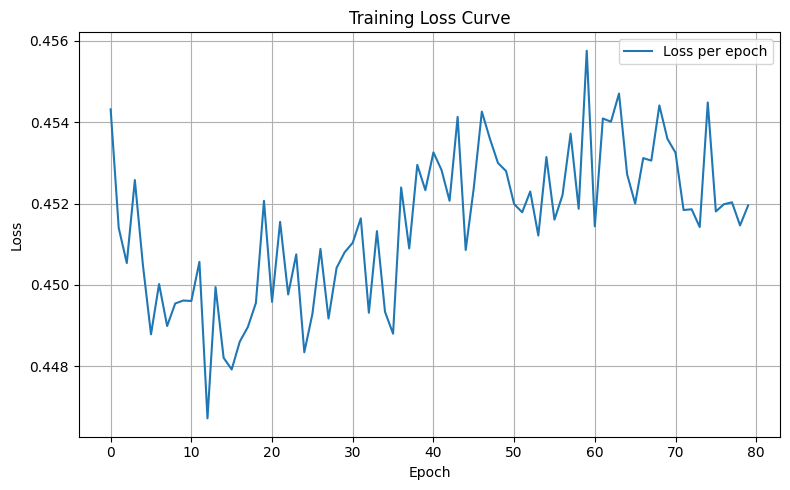

In [5]:
model.optimize_weights(X_train, y_train)

In [10]:
for name, value in model.__dict__.items():
    print(f"{name}: {type(value)}")

params: <class 'naf.naf_model.NAFParams'>
forest: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
run_agent: <class 'NoneType'>
onehot_encoder: <class 'sklearn.preprocessing._encoders.OneHotEncoder'>
training_xs: <class 'numpy.ndarray'>
training_y: <class 'scipy.sparse._csr.csr_matrix'>
training_leaf_ids: <class 'numpy.ndarray'>
leaf_sparse: <class 'numpy.ndarray'>
n_trees: <class 'int'>
nn: <class 'naf.naf_nn.NAFNetwork'>
device: <class 'torch.device'>


In [15]:
def save_model_fields(model, path: str):
    os.makedirs(path, exist_ok=True)

    for key, value in model.__dict__.items():
        try:
            joblib.dump(value, os.path.join(path, f"{key}.pkl"))
            print(key)
        except Exception as e:
            print(f"❌ Failed to save {key}: {e}")

In [13]:
def load_model_fields(cls, path: str):
    obj = cls.__new__(cls)  # создать объект без вызова __init__
    for file in tqdm(os.listdir(path), desc='load'):
        if file.endswith(".pkl"):
            key = file[:-4]
            try:
                value = joblib.load(os.path.join(path, file))
                setattr(obj, key, value)
            except Exception as e:
                print(f"❌ Failed to load {key}: {e}")
    return obj

In [14]:
model_loaded = load_model_fields(NeuralAttentionForest, "model")

load:   0%|          | 0/11 [00:00<?, ?it/s]

load: 100%|██████████| 11/11 [00:20<00:00,  1.85s/it]

❌ Failed to load leaf_sparse: EOF: reading array data, expected 262144 bytes got 0


In [5]:
X_test = preprocess_data(X_test, 'LARF/transform_data_pipeline.pkl')

In [12]:
y_proba = model_loaded.predict(X_test)[:, 1]
#y_proba = model.predict(X_test)

AttributeError: 'NeuralAttentionForest' object has no attribute 'leaf_sparse'

In [6]:


thresholds = np.linspace(0, 1, 100)

beta = 2

max_f1_vals = []
max_f1_args = []

f1_scores = []

y_true = np.array([1 if label == 0 else 0 for label in y_test])
for thr in thresholds:
    y_pred = (np.array([1 - score for score in y_proba]) >= 1 - thr).astype(int)
    f1 = fbeta_score(y_true, y_pred, beta=beta)
    f1_scores.append(f1)

f1_scores = np.array(f1_scores)
max_f1 = f1_scores.max()
arg_f1 = f1_scores.argmax()

print(f'max F2 = {max_f1:.3f}, threshold = {arg_f1 / 100}')

KeyboardInterrupt: 

In [30]:
!python NAF/naf/changes_test.py

⏳ data loading...
✅ data loaded successfully...
⏳ gpu model fit...
Start fitting Random forest
Random forest fit time: 0.272776
Random forest apply time: 0.033510
Generating leaves data
bytecode dump:
>          0	NOP(arg=None, lineno=27)
           2	RESUME(arg=0, lineno=27)
           4	LOAD_FAST(arg=1, lineno=37)
           6	LOAD_METHOD(arg=0, lineno=37)
          28	PRECALL(arg=0, lineno=37)
          32	CALL(arg=0, lineno=37)
          42	STORE_FAST(arg=2, lineno=37)
          44	LOAD_FAST(arg=2, lineno=38)
          46	LOAD_CONST(arg=1, lineno=38)
          48	BINARY_OP(arg=0, lineno=38)
          52	STORE_FAST(arg=3, lineno=38)
          54	LOAD_FAST(arg=1, lineno=39)
          56	LOAD_ATTR(arg=1, lineno=39)
          66	LOAD_CONST(arg=1, lineno=39)
          68	BINARY_SUBSCR(arg=None, lineno=39)
          78	STORE_FAST(arg=4, lineno=39)
          80	LOAD_FAST(arg=0, lineno=40)
          82	LOAD_ATTR(arg=1, lineno=40)
          92	LOAD_CONST(arg=2, lineno=40)
          94	BINAR